# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext Ddip
%makedip -g all -a fastai_v1 --verbose True

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-ippdpp_c-client.json


Connecting to ipyparallel cluster.......

Initializing torch distributed group with GPUs [0, 1, 2]
Local Ranks initialized:  ['GPU0=0', 'GPU1=1', 'GPU2=2']
Importing on cluster: ['import fastai, fastai.torch_core, torch, fastprogress', 'from fastai.distributed import *', 'from ippddp.ddipp.fastai_v1 import initializer, finalizer, set_verbose, lr_find_bypass']
fastai_v1:
[Process 19239] Rank 0 fastai initialized for distributed data parallel.
[Process 19243] Rank 1 fastai initialized for distributed data parallel.
[Process 19244] Rank 2 fastai initialized for distributed data parallel.


In [2]:
%%dip everywhere
from fastai.text import *

%%dip everywhere: Running cell in local namespace.
%%dip everywhere: Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/ndim1/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [7]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [8]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [9]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [11]:
data.train_ds[0][0]

Text xxbos i rated this film 7 / 10 which is an average of 8 / 10 for screenplay , direction and 1944 production values and 6 / 10 for acting . xxmaj my acting rating in turn was xxunk at 4 / 10 for all the screen characters except for that played by heroine xxmaj ella xxmaj raines as xxmaj carol xxmaj xxunk who was excellent at 8 / xxunk i commend xxmaj thomas xxmaj xxunk as xxmaj inspector xxmaj burgess whose character convinces that he personally does not think the guilty verdict on xxmaj scott xxmaj henderson ( xxmaj alan xxmaj curtis ) was just in view of his naive alibi . xxmaj these two then form an alliance to prove xxmaj scott 's alibi . 
 
  i have this film on a " xxmaj xxunk xxmaj film xxmaj noir xxmaj xxunk xxmaj xxunk " xxup dvd in xxmaj spanish as " xxmaj la xxmaj xxunk xxmaj xxunk " with the original soundtrack " xxmaj xxunk " as an alternative language , since despite searching i could not find a wholly xxmaj english version . i was however xxunk to see another perform

But the underlying data is all numbers

In [13]:
data.train_ds[0][0].data[:10]

array([   2,   19, 1046,   21,   32,  802,  115,  164,   85,   16])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [14]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [3]:
# bs=48
bs=64

Now let's grab the full dataset for what follows.

In [4]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/ndim1/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/ndim1/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/ndim1/.fastai/data/imdb/models'),
 PosixPath('/home/ndim1/.fastai/data/imdb/README'),
 PosixPath('/home/ndim1/.fastai/data/imdb/unsup'),
 PosixPath('/home/ndim1/.fastai/data/imdb/tmp'),
 PosixPath('/home/ndim1/.fastai/data/imdb/data_clas.pkl'),
 PosixPath('/home/ndim1/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/ndim1/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/ndim1/.fastai/data/imdb/train'),
 PosixPath('/home/ndim1/.fastai/data/imdb/test')]

In [5]:
(path/'train').ls()

[PosixPath('/home/ndim1/.fastai/data/imdb/train/neg'),
 PosixPath('/home/ndim1/.fastai/data/imdb/train/pos'),
 PosixPath('/home/ndim1/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/ndim1/.fastai/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [8]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [5]:
%dipush bs path
%autodip on

Pushing parameters to DDP namespace: ['bs', 'path']
Auto Execution on DDP group: on, will run cell as %%dip


We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [6]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [7]:
data_lm.show_batch()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

idx,text
0,"of xxmaj ajax and xxmaj parry of the xxmaj new xxmaj zealand ship xxmaj achilles , gambling that the xxmaj germans will head for the xxmaj river xxmaj plate before returning home . \n \n a fierce battle rages throughout the following day , with xxmaj exeter suffering heavy damage . xxmaj the xxmaj graf xxmaj spee escapes under cover of nightfall to neutral xxmaj montevideo harbour where ,"
1,a lot of movies when this movie came out and i noticed in the paper a listing for xxmaj bad xxmaj moon . xxmaj so i decided since i had xxunk seen every other movie playing in the theater to give it a try . xxmaj it was opening day of the movie and i notice that only three other people in the theater had come to see it .
2,as she was . xxmaj the real story behind it is such a tragedy . xxmaj poor xxmaj irene xxmaj silverman and other victims who was so suspicious and caught on to their act only to get murdered and discarded like garbage . xxmaj it is such a shame that they never found her body and probably never will at this point . xxmaj but what gall is that they
3,"i think he would have far better in the role of xxmaj norman xxmaj main . xxmaj after xxmaj judy xxmaj garland was fired from xxmaj annie xxmaj get xxmaj your xxmaj gun , the first person that they wanted to play xxmaj annie was xxmaj betty xxmaj garrett , but because of her an - gent she lost out having the role of a lifetime in the movies ,"
4,"best and only possibility for a new century audience . xxbos 1st watched 2 / 13 / 2007 - 1 out of 10(dir - xxmaj dwain xxmaj esper ) : xxmaj absolutely horrible excuse for a movie . i mean , if it did it 's job of educating the public against syphilis it might have been somewhat worthwhile , but even this attempt was executed very badly . xxmaj"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [8]:
%%dip -S all
data_lm.device

%%dip -S all: Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


Out[0:4]: device(type='cuda', index=0)

Out[1:4]: device(type='cuda', index=1)

Out[2:4]: device(type='cuda', index=2)

In [9]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [14]:
learn.lr_find()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
Proc [18240] Rank [0] Removing callback <class 'fastai.distributed.DistributedTrainer'> from learner.
Proc [18240] Rank [0] Removing callback <class 'fastai.distributed.DistributedRecorder'> from learner.
Proc [18240] Rank [0] Running lr_find() in non DDP mode
Proc [18244] Rank [1] cannot run lr_find() in DDP mode (only Rank [0] can).
Proc [18245] Rank [2] cannot run lr_find() in DDP mode (only Rank [0] can).
epoch     train_loss  valid_loss  accuracy  time    
0         13.113811   #na#        00:18     ---------| 1.64% [99/6048 00:18<18:19 11.5804]
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

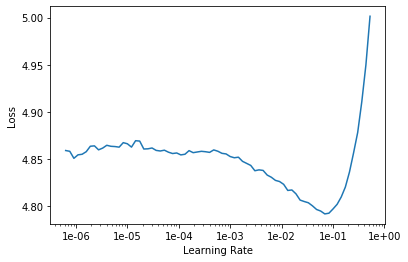

In [15]:
learn.recorder.plot(skip_end=15)

In [16]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  accuracy  time    
0         3.948259    3.906367    0.301439  09:25                                            


In [17]:
learn.save('fit_head')

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [18]:
learn.load('fit_head');

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


To complete the fine-tuning, we can then unfeeze and launch a new training.

In [13]:
learn.unfreeze()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [14]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  accuracy  time    
0         4.147244    4.069795    0.313324  12:17                                            


In [15]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  accuracy  time    
0         4.025886    3.994853    0.318539  12:08                                             
1         3.893934    3.847466    0.327336  12:09                                             
2         3.723466    3.738838    0.333429  12:09                                             
3         3.635816    3.678081    0.337518  12:10                                             
4         3.564397    3.643063    0.339820  12:10                                             
5         3.507471    3.618983    0.341879  12:10                                             
6         3.444421    3.603808    0.343339  12:10                                             
7         3.403359    3.593566    0.344421  12:10                                             
8         3.373981    3.589162    0.345017  12:10                                             
9         3.352196    3.5883

How good is our model? Well let's try to see what it predicts after a few given words.

In [16]:
learn.save('fine_tuned-ddp');

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:100: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [17]:
learn.load('fine_tuned-ddp');

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [18]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [19]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
I liked this movie because it has a good story line , and a good performance by Sean Bean , who had a great role in this movie ! ! ! It is n't Oscar material , but it makes fun
I liked this movie because it was great to see Jon Voight and Susan Sarandon do a movie together . It 's about a very man who has a son . So he and his son move onto a
I liked this movie because it did n't give you too many twists and turns , but so did the music and the movie . i would recommend this movie to fans of the Matrix . The movie is not just action ,
I liked this movie because of the title . It has a good story about the two leads , Weir and Weir . The only thing seemed to be a little bit of a plot twist . The direction was
I liked this movie because of the good acting and the great script . It 's filled with clever and realistic situations and Hollywood still has n't found a new way to make movies . It does have some very good actors
I l

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [20]:
learn.save_encoder('fine_tuned_enc-ddp')

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [22]:
%autodip off
%makedip -k
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load('fit_head')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))
learn.save('fine_tuned-single');
learn.save_encoder('fine_tuned_enc-single')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc-single')
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
learn.save('first-single')
learn.load('first-single')

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save('second-single')
learn.load('second-single')

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.save('third-single')
learn.load('third-single')

learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.predict("I really loved that movie, it was awesome!")
learn.save('last-single')


Auto Execution on DDP group: Off


Shutting down cluster....


DDP.exit_group(): [0, 1, 2]


The cluster takes a few secons to shut down....


epoch,train_loss,valid_loss,accuracy,time
0,3.795089,3.764953,0.318825,22:04
1,3.765301,3.724154,0.326427,22:05
2,3.715838,3.696973,0.330910,22:06
3,3.666868,3.666649,0.334794,22:06
4,3.624236,3.642181,0.338301,22:05
5,3.573047,3.621949,0.340508,22:05
6,3.493925,3.606817,0.342836,22:06
7,3.419490,3.601450,0.343797,22:05
8,3.377777,3.600045,0.344160,22:05
9,3.331737,3.602314,0.344029,22:06


epoch,train_loss,valid_loss,accuracy,time
0,0.246588,0.178410,0.932320,01:59


epoch,train_loss,valid_loss,accuracy,time
0,0.227889,0.161970,0.939600,02:15


epoch,train_loss,valid_loss,accuracy,time
0,0.197898,0.148056,0.944520,03:24


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 10.91 GiB total capacity; 10.08 GiB already allocated; 25.44 MiB free; 188.75 MiB cached)

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [27]:
path = untar_data(URLs.IMDB)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


In [28]:
%%dip local
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

%%dip local: Running cell in local namespace.


In [35]:
%autodip off

Auto Execution on DDP group: Off


In [36]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [37]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj by now you 've probably heard a bit about the new xxmaj disney dub of xxmaj miyazaki 's classic film , xxmaj laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky . xxmaj during late summer of 1998 , xxmaj disney released "" xxmaj kiki 's xxmaj delivery xxmaj service "" on video which included a preview of the xxmaj laputa dub saying it was due out",pos
"xxbos * * * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . * * * \n \n xxmaj before i begin , i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that",neg
"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxup xxunk "" and "" xxup beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this",neg
"xxbos i thought that xxup rotj was clearly the best out of the three xxmaj star xxmaj wars movies . i find it surprising that xxup rotj is considered the weakest installment in the xxmaj trilogy by many who have voted . xxmaj to me it seemed like xxup rotj was the best because it had the most profound plot , the most suspense , surprises , most xxunk the",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [38]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj the first xxmaj matrix movie was lush with incredible character development , witty dialog , and action scenes that kept with the flow of the story . xxmaj these elements -- coupled by incredible special effects of the day -- presented a magical ride that kept you in suspense the entire time . xxmaj enter xxmaj matrix xxmaj reloaded ( and its sequel , xxmaj revolutions ) . xxmaj the problem here is n't the special effects or the fight sequences as some may argue ; xxmaj the brothers have taken well - developed characters from the first film and hollowed them out like rotten tree logs . 
  xxmaj the connection that was first established between viewers and on - screen characters in the first film is lost when you realize these are not the same characters from the first xxmaj matrix movie . 
 
  xxmaj to wit , xxmaj morpheus was developed as a charismatic , philosophical character with insight far 

In [32]:
learn.lr_find()

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
Proc [18240] Rank [0] Removing callback <class 'fastai.distributed.DistributedTrainer'> from learner.
Proc [18240] Rank [0] Removing callback <class 'fastai.distributed.DistributedRecorder'> from learner.
Proc [18240] Rank [0] Running lr_find() in non DDP mode
Proc [18244] Rank [1] cannot run lr_find() in DDP mode (only Rank [0] can).
Proc [18245] Rank [2] cannot run lr_find() in DDP mode (only Rank [0] can).
epoch     train_loss  valid_loss  accuracy  time    
0         4.296188    #na#        00:18     ---------| 24.10% [94/390 00:18<00:57 2.4029]
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).


[output:0]

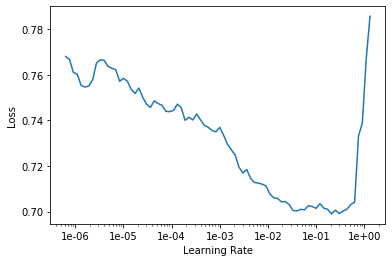

In [33]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.586601,0.530112,0.737600,02:09


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255913,0.169186,0.937800


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.223174,0.165679,0.939600


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.240424,0.155204,0.943160
2,0.217462,0.153421,0.943960


In [ ]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))